In [1]:
from PIL import Image
from skimage import measure
from skimage import color
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from skimage import io
from PIL import Image
import tifffile as tiff

Image_folder = 'Y:\coskun-lab\Thomas\Mayar-Data\Image'
Mask_folder = 'Y:\coskun-lab\Thomas\Mayar-Data\Mask'
Cluster_folder = 'Y:\coskun-lab\Thomas\Mayar-Data\Clusters'

%matplotlib inline

In [2]:
# Experiment
# experiments = ['DT14', 'DT15', 'NT1 ROI004', 'NT1 ROI005', 'NT2 ROI003','NT2 ROI004', 'NT2L', 'NT2R', 'ROI005 Area 1', 'ROI006 Area 2', 'ROI007 Area 1', 'ROI008 Area 2']
# conditions = ['Diseased', 'Diseased', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Diseased', 'Diseased', 'Diseased', 'Diseased']

# experiments = ['NT1 ROI005', 'NT2 ROI004', 'NT2L','DT14', 'ROI005 Area 1', 'ROI007 Area 1']
# conditions = ['Healthy', 'Healthy', 'Healthy', 'Diseased', 'Diseased', 'Diseased']

experiments = [ 'NT1 ROI004', 'NT1 ROI005', 'NT2 ROI003','NT2 ROI004', 'ROI005 Area 1', 'ROI006 Area 2', 'ROI007 Area 1', 'ROI008 Area 2']
conditions = [ 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Diseased', 'Diseased', 'Diseased', 'Diseased']



df = pd.DataFrame()

for n in range(len(experiments)):
    experiment = experiments[n]

    markers = []
    imgs = []    
    masks = []

    for (dirpath, dirnames, filenames) in os.walk(Image_folder):
        for name in sorted(filenames):
            if 'tiff' in name and experiment in name:
                img = cv2.imread(os.path.join(dirpath,name),flags=(cv2.IMREAD_GRAYSCALE | cv2.IMREAD_ANYDEPTH))
                imgs.append(img)
                markers.append(name.split('_')[1].split('.')[0])
                

    for (dirpath, dirnames, filenames) in os.walk(Mask_folder):
        for name in sorted(filenames):
            if 'BM' in name and experiment in name:        
                img = cv2.imread(os.path.join(dirpath,name),0)
                masks.append(img)
                
    # Read cell mask image 
    for (dirpath, dirnames, filenames) in os.walk(Mask_folder):
        for name in sorted(filenames):
            if 'Cell_Mask' in name and experiment in name:
                cell_mask = np.array(Image.open(os.path.join(dirpath,name)))
            
    for i in range(len(markers)):
        if markers[i] == 'ECadherin':
            markers[i] = 'Ecadherin'
        if markers[i] == 'PanKeratin':
            markers[i] = 'Pankeratin'
        if markers[i] == 'Vimetin':
            markers[i] = 'Vimentin'
        if markers[i] == 'Histone3':
            markers[i] = 'H3'
        if markers[i] == 'FOXP3':
            markers[i] = 'FoxP3'

    # Read mean intensity of marker in cell 
    cell_intensity = {}
    for i in range(len(imgs)):
#         prop = measure.regionprops_table(cell_mask, imgs[i], properties = ['mean_intensity'])
        prop = measure.regionprops_table(cell_mask, cv2.bitwise_and(imgs[i], imgs[i], mask = masks[i]), properties = ['mean_intensity'])
        cell_intensity[markers[i]] = prop['mean_intensity']
        
    df_temp = pd.DataFrame.from_dict(cell_intensity)
#     df_temp = ((df_temp-df_temp.min())/(df_temp.max()-df_temp.min()))
    df_temp['condition'] = conditions[n]
    df = df.append(df_temp, ignore_index=True)

df = df.drop(columns=['CD44', 'H3K4me3', 'MHCII'])

In [3]:
# for i in range(len(imgs)):
#     img_masked = cv2.bitwise_and(imgs[i], imgs[i], mask = masks[i])
#     print(markers[i])
#     plt.figure(figsize=(15,8))
#     plt.imshow(img_masked,cmap='gray')

In [4]:
# Group markers by cell type 
Tcell_markers = ['CD3', 'CD4', 'CD8a', 'CD45RO', 'FoxP3']
Icell_markers = ['CD20', 'CD68', 'GranzymeB']
Ecell_markers = ['Ki67', 'Pankeratin', 'SMA', 'Vimentin', 'Ecadherin', 'Col1']
all_markers = list(df.columns)[:-1]

In [5]:
def get_df(markers):
    cols = ['Intensity', 'Marker', 'Condition']
    df_temp = pd.DataFrame(columns=cols)
    for ele in markers:
        temp = pd.DataFrame(df[[ele]].values, columns=['Intensity'])
        temp['Marker'] = ele
        temp['Condition'] = df.condition
        df_temp = df_temp.append(temp, ignore_index=True)

    return df_temp

df = get_df(all_markers)

In [10]:
blue_red = ["#3498db", "#e74c3c"]
my_pal = sns.color_palette(blue_red)

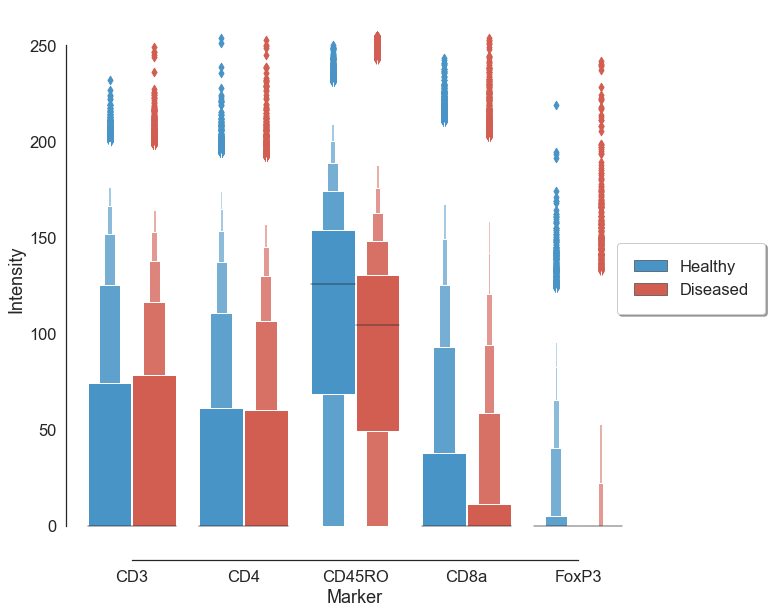

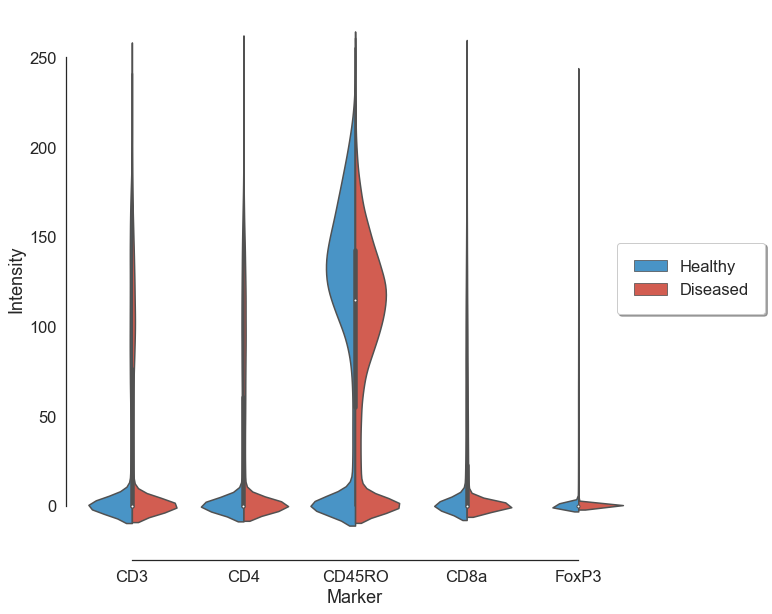

In [11]:
df_TCell = df[df.Marker.isin(Tcell_markers)]

sns.set_style("white")
sns.set(font_scale=1.5)

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.boxenplot(x='Marker', y="Intensity", hue='Condition', data=df_TCell, palette = my_pal)
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    sns.despine(offset=10, trim=True, bottom=False);
    fig.savefig("intensity1.png" ,bbox_inches='tight')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.violinplot(x='Marker', y="Intensity", hue='Condition', data=df_TCell, palette = my_pal, split=True, legend_out=True)
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), fancybox=True, framealpha=1, shadow=True, borderpad=1)
    sns.despine(offset=10, trim=True, bottom=False);
    fig.savefig("intensity2.png", bbox_inches='tight')

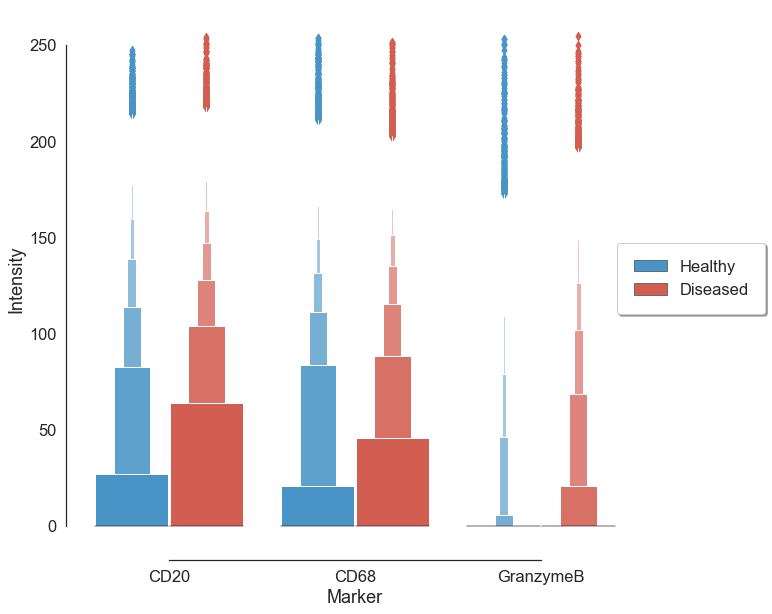

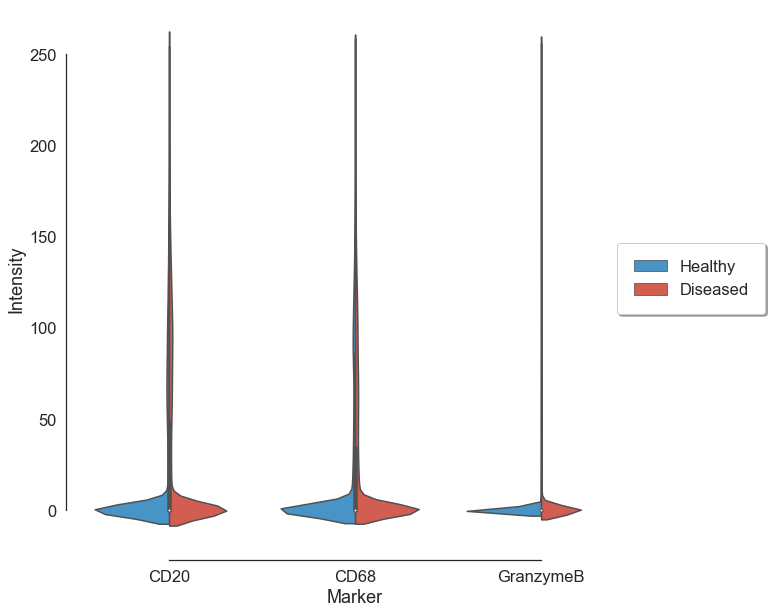

In [12]:
df_ICell = df[df.Marker.isin(Icell_markers)]

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.boxenplot(x='Marker', y="Intensity", hue='Condition', data=df_ICell, palette = my_pal)
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, fancybox=True, framealpha=1, shadow=True, borderpad=1)
    sns.despine(offset=10, trim=True, bottom=False);
    fig.savefig("intensity3.png",bbox_inches='tight')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.violinplot(x='Marker', y="Intensity", hue='Condition', data=df_ICell, palette = my_pal, split=True)
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, fancybox=True, framealpha=1, shadow=True, borderpad=1)
    sns.despine(offset=10, trim=True, bottom=False);
    fig.savefig("intensity4.png",bbox_inches='tight')

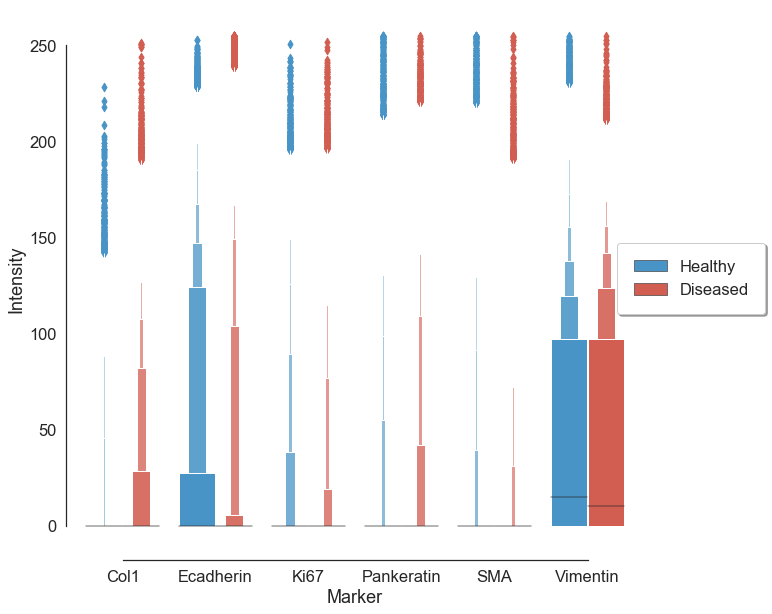

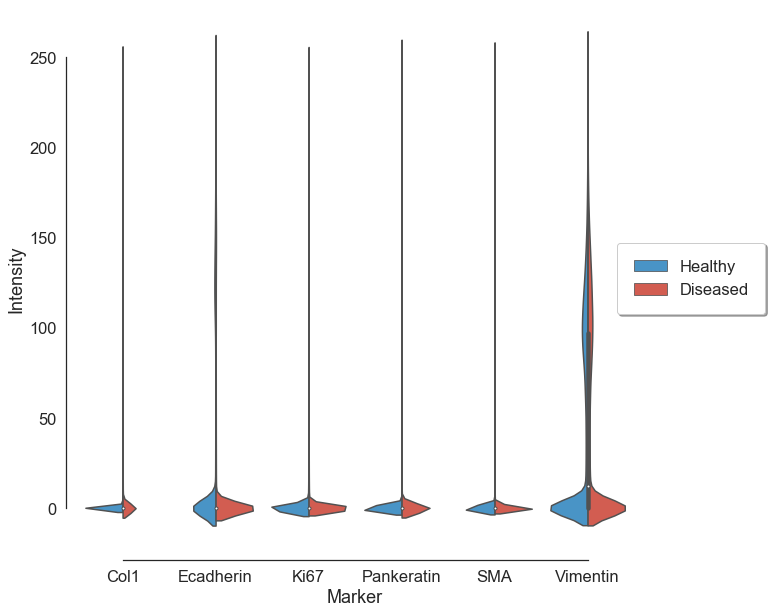

In [13]:
df_ECell = df[df.Marker.isin(Ecell_markers)]

with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.boxenplot(x='Marker', y="Intensity", hue='Condition', data=df_ECell, palette = my_pal)
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, fancybox=True, framealpha=1, shadow=True, borderpad=1)
    sns.despine(offset=10, trim=True, bottom=False);
    fig.savefig("intensity5.png",bbox_inches='tight')
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.violinplot(x='Marker', y="Intensity", hue='Condition', data=df_ECell, palette = my_pal, split=True)
    ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1, fancybox=True, framealpha=1, shadow=True, borderpad=1)
    sns.despine(offset=10, trim=True, bottom=False);
    fig.savefig("intensity6.png",bbox_inches='tight')